# 住宅販売価格の予測(DAY2)

データセットダウンロード元  
https://www.kaggle.com/harlfoxem/housesalesprediction/data

### DAY2の目標
DAY1の予測をより精度の高いものにするための見直しを行う

#### 前回の精度）
MSE = 0.025,RMSE = 0.158,MAE = 0.091

#### 見直しの方針）

| 項目 | 概要 |
| :--- | :--- |
| 基礎集計の見直し | 前回の課題提出時に指摘があった<BR>外れ値の処理について考察を加える |
|データ前処理・特徴量抽出の見直しを追加 | 前回のデータ前処理・特徴量抽出で作成されたfeatureに対して、<BR>ランダムフォッレストによる分析を加えてfeatureの見直しを図る
| パラメータの調整の追加 | 学習前にグリッドサーチによるパラメータの最適化を行う |

### 処理の流れ
DAY2の見直しの方針に従い、処理の流れは以下の通りに変更する

#### DAY1の流れ
1. 基礎集計、グラフ化
2. データ前処理
3. 特徴量抽出
4. モデルの学習
5. モデルの評価

#### DAY2の流れ
1. 基礎集計、グラフ化 →　外れ値の考察を追加
2. データ前処理
3. 特徴量の抽出
4.　特徴量の見直し　→　追加
5. モデルのパラメータの調整　→　追加
6. モデルの学習
7. モデルの評価


## 0. 実行前準備

In [78]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from mpl_toolkits.basemap import Basemap

In [2]:
df_data = pd.read_csv("1_data/kc_house_data.csv")
df_data["price"] = df_data["price"] / 10**6 #単位を1万ドルにしておく

## 1.基礎集計、グラフ化

In [3]:
print(df_data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


### カラムメタデータ

|  ラベル | 概要 | 種別 |
---|---|---
| id | ID | 数値 |
| date | 販売日 | 文字列 |
| price | 価格(予測対象) | 数値 |
| bedrooms | ベッドルームの数 | 数値 |
| bathrooms | バスルームの数 | 数値 |
| sqft_living | リビングルームの広さ | 数値 |
| sqft_lot | 駐車場の広さ | 数値 |
| floors | 階数 | 数値 |
| waterfront | ウォーターフロントを望む家(0,1) | 文字列 |
| view | ビューの種類(0,1,2,3,4) | 文字列 |
| condition | 状態（1,2,3,4,5) | 文字列 |
| grade | グレード(1~13) | 文字列 |
| sqft_above | 地上階の広さ | 数値 |
| sqft_basement | 地下の広さ | 数値 |
| yr_built | 建築年 | 数値 |
| yr_renovated | 家が改築された年 | 数値 |
| zipcode | 郵便番号 | 数値 |
| lat | 緯度座標 | 数値 |
| long | 経度座標 | 数値 |
| sqft_living15 | 近所15件の平均のリビングの広さ | 数値 |
| sqft_lot15 | 近所15件の駐車場の広さ | 数値 |

参照）https://www.slideshare.net/ssuserb5817c/python-66169435  
補足)アメリカの住宅のバスルームの数え方 https://ameblo.jp/ayako-america/entry-11781058914.html

In [4]:
stringLabels = ["date","waterfront","view","condition","grade"]

方針）　文字列データはone-hotベクトルに変換する

### ヘッダを表示

In [5]:
df_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,0.2219,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,0.5380,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,0.1800,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,0.6040,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,0.5100,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


方針）　dateは日付型に変換する

In [6]:
df = df_data.drop(stringLabels+ ["id"],axis=1)

方針) idは価格に影響しないと考えられるため削除

### 散布図

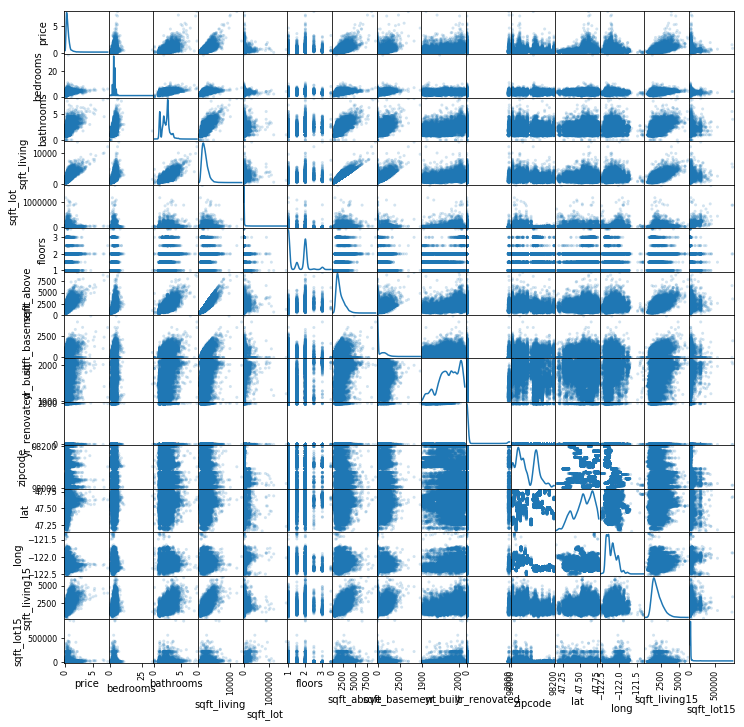

In [7]:
plt.figure()
scatter_matrix(df,alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

考察）floors,zipcode,lat,longは有効か要検討

### ヒートマップ

In [8]:
#相関行列
df.corr().style.background_gradient().format('{:.2f}')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.00,0.31,0.53,0.70,0.09,0.26,0.61,0.32,0.05,0.13,-0.05,0.31,0.02,0.59,0.08
bedrooms,0.31,1.00,0.52,0.58,0.03,0.18,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03
bathrooms,0.53,0.52,1.00,0.75,0.09,0.50,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09
sqft_living,0.70,0.58,0.75,1.00,0.17,0.35,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18
sqft_lot,0.09,0.03,0.09,0.17,1.00,-0.01,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72
floors,0.26,0.18,0.50,0.35,-0.01,1.00,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01
sqft_above,0.61,0.48,0.69,0.88,0.18,0.52,1.00,-0.05,0.42,0.02,-0.26,-0.00,0.34,0.73,0.19
sqft_basement,0.32,0.30,0.28,0.44,0.02,-0.25,-0.05,1.00,-0.13,0.07,0.07,0.11,-0.14,0.20,0.02
yr_built,0.05,0.15,0.51,0.32,0.05,0.49,0.42,-0.13,1.00,-0.22,-0.35,-0.15,0.41,0.33,0.07
yr_renovated,0.13,0.02,0.05,0.06,0.01,0.01,0.02,0.07,-0.22,1.00,0.06,0.03,-0.07,-0.00,0.01


- 相関性が70%以上と高い項目）　　
 - priceとsqft_living
 - bathroomsとsqft_living
 - sqft_livingとgrade
 - sqft_livingとsqft_above
 - sqft_livingとsqft_living15
 - sqft_lotとsqft_lot15
 - gradeとsqft_living15
 - sqft_living,sqft_above,sqft_lot,sqft_lot15,sqft_living15は相関性が高い項目が複数ある。

考察） 多重共線性の可能性あり 。相関性が高い項目に対して多重共線性がないか確認する

### 多重共線性の確認

In [9]:
delta = 1e-04
for cname in df.columns:  
    y=df[cname]
    X=df.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    rsquared = regr.score(X,y)
    vif = 1/(1-rsquared+delta)
    if vif >= 10:
        print(cname, ":", vif, ":", rsquared)

sqft_living : 10000.0 : 1.0
sqft_above : 10000.0 : 1.0
sqft_basement : 10000.0 : 1.0


方針）　VIFが10以上の上記の項目は前処理で削除する

### 欠損地の確認

In [10]:
df_data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

考察）欠損値はない

### 価格の分布

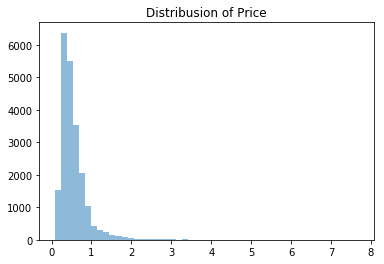

In [11]:
plt.hist(df['price'], bins=50, alpha=0.5)
plt.title('Distribusion of Price')
plt.show()

考察） 横軸が極端に長いので外れ値があるかもしれない

### 基本統計量

In [12]:
df.describe ()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,0.540088,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,0.367127,0.930062,0.770163,918.440897,4.142051e+04,0.539989,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,0.075000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,0.321950,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,0.450000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,0.645000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### 箱ひげ図
外れ値を確認

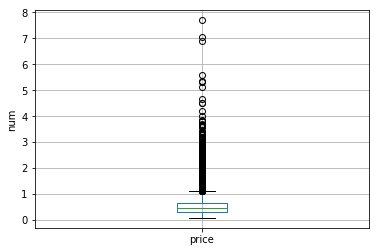

In [13]:
df_data.boxplot(column='price')
plt.ylabel("num")
plt.show()

### 外れ値を削除した場合の箱ひげ図

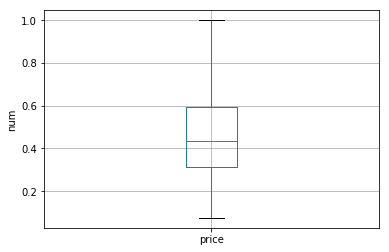

In [18]:
df2 = df_data[df_data["price"] < 1.0]
df2.boxplot(column='price')
plt.ylabel("num")
plt.show()

##### DAY2追加）
10万ドル以上の件数の比率を求める

In [19]:
print( "10万ドル以上の比率", len(df_data[df_data["price"] >= 1.0].index)/len(df_data))

10万ドル以上の比率 0.06903252672002962


前回外れ値と扱った10万ドル以上の物件について、１０万ドル未満の物件と特徴量に差異がないかランダムフォレストを用いて比較を行う

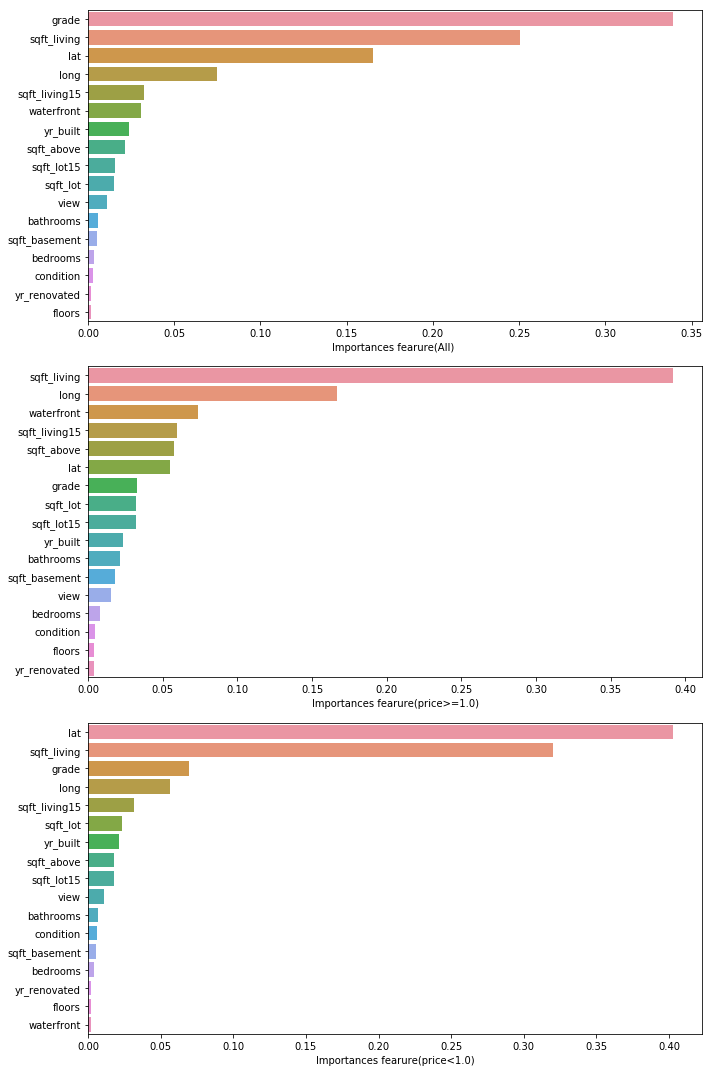

In [21]:
# 目的変数対象のカラム名
x_columns = ['bedrooms', 'bathrooms', 'sqft_living', \
                   'sqft_lot', 'floors', 'waterfront','view','condition', 'grade','sqft_above', 'sqft_basement', \
                   'yr_built', 'yr_renovated','lat','long','sqft_living15', 'sqft_lot15']

# 分類別の図表ラベル
labels = ["Importances fearure(All) ", "Importances fearure(price>=1.0)", "Importances fearure(price<1.0)"]

# 変数領域確保
y_trains = []
X_trains = []

# 全体の目的変数と説明変数
y_trains.append(df_data['price'])
X_trains.append(df_data[x_columns])

# 10万ドル以上の目的変数と説明変数
df_overs = df_data[df_data["price"] >= 1.0]
y_trains.append(df_overs['price'])
X_trains.append(df_overs[x_columns])

# 10万ドル未満の目的変数と説明変数
df_lowers = df_data[df_data["price"] < 1.0]
y_trains.append(df_lowers['price'])
X_trains.append(df_lowers[x_columns])

# ランダムフォルストのインスタンスを生成
rf = RandomForestRegressor(n_estimators=20, max_features='auto')

# 図表表示領域
f, axs = plt.subplots(3, 1, figsize=(10, 15))

# 分類別にランダムフォレスで特徴量の重要度を求めグラフに表示する
for i, (label, X_train, y_train) in enumerate(zip(labels, X_trains, y_trains)):
    rf.fit(X_train, y_train)
    ranking = np.argsort(-rf.feature_importances_)
    sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h',ax=axs[i])
    axs[i].set_xlabel(label)

plt.tight_layout()
plt.show()

#### DAY2追加の考察）
分類ごとに重視する特徴量が変わるため、分布として異なることが推察される。   
また、緯度、経度が重要な特徴量となっているので、どのように分類になっているか地図上にプロットして考察を行う

地図を表示するにあたり、表示空間の位置と大きさを算出する

In [22]:
# 緯度経度の最小値・最大値を求める
min_lat,max_lat = df_data['lat'].min(),df_data['lat'].max()
min_long,max_long = df_data['long'].min(),df_data['long'].max()

#　中央値を求める
center_lat = (max_lat + min_lat)/2
center_long = (max_long + min_long)/2

# 差分を求め　、表示領域を求める
dif_lat = max_lat - min_lat
dif_long = max_long - min_long
map_width = dif_lat * 150000  # 余白を含めてざっくり
map_height = dif_long * 60000 # 余白を含めてざっくり

print('lat =(',min_lat,',',max_lat,') diff=',dif_lat)
print('long =(',min_long,',',max_long,') diff=',dif_long)
print()
print('map_width=',map_width, ' map_height=',map_height)
print('center_lat=',center_lat,' center_long=',center_long)

lat =( 47.1559 , 47.7776 ) diff= 0.621699999999997
long =( -122.51899999999999 , -121.315 ) diff= 1.2039999999999935

map_width= 93254.99999999955  map_height= 72239.9999999996
center_lat= 47.466750000000005  center_long= -121.917


/Users/kohsaku/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/kohsaku/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


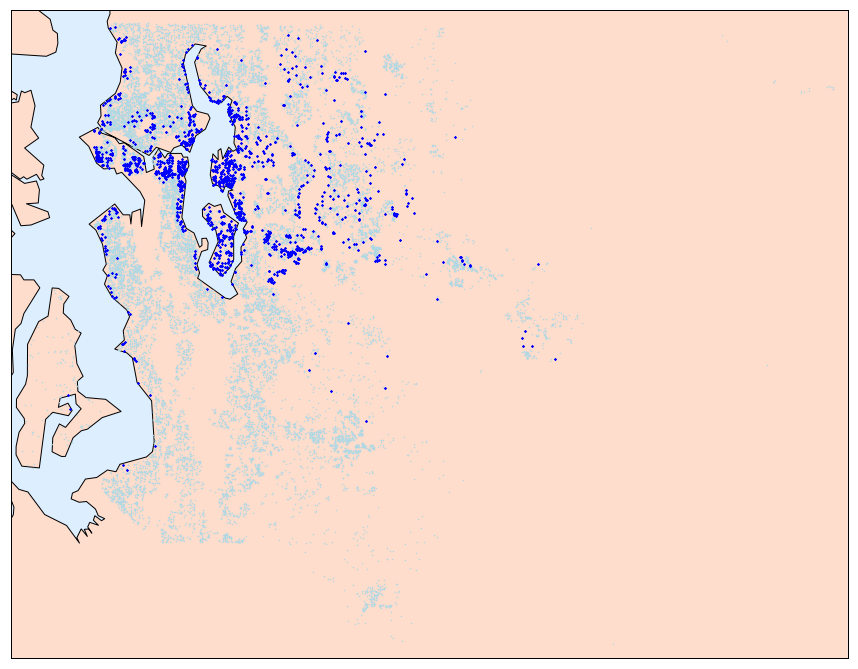

In [24]:
fig = plt.figure(figsize=(15, 15))
m = Basemap(projection='lcc', resolution='h',
            width=map_width, height=map_height, 
            lat_0=center_lat, lon_0=center_long)
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

# Map (long, lat) to (x, y) for plotting
for i, row in df_lowers.iterrows():
    x,y  =m(row['long'], row['lat'])
    plt.plot(x, y, color='lightblue', marker='.', markersize=1)
    
for i, row in df_overs.iterrows():
    x,y  =m(row['long'], row['lat'])
    plt.plot(x, y, color='blue', marker='*', markersize=2)


#### DAY2追加の考察）
高額(10万ドル以上)物件は、ワシントン湖の周りなど特定の場所に集中している。また、特徴量の重要度が
異なることもあり、今回は分析の対象外とする

##### DAY2追加）標準化の影響を調べる

In [25]:
def scalerDataFrame(orgDataFrame,columnNames):
    columnNames = orgDataFrame.columns
    scaler = StandardScaler()
    scDataFrame = scaler.fit_transform(orgDataFrame)  
    # sklearnの上記のようなfit関連の実行後、データの書式がnumpy形式となりカラム(列)名が無くなる。
    # そのため、再度、pandas形式に変換する(次の2行)。これはグラフの軸名で使用するため。
    scDataFrame = pd.DataFrame(scDataFrame)
    scDataFrame.columns = columnNames
    return scDataFrame

X_train_sc = scalerDataFrame(X_train,X_train)
X_train_sc.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04,2.012100e+04
mean,1.599149e-16,1.365892e-14,-1.262899e-16,-6.584586e-17,-2.227696e-15,1.589611e-15,2.943131e-15,-6.567371e-15,4.699150e-16,-3.265394e-17,5.550221e-15,1.776246e-15,3.209196e-16,5.685168e-14,1.414320e-14,3.989983e-16,-2.219784e-17
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00
min,-3.646236e+00,-2.898470e+00,-2.203544e+00,-3.498375e-01,-8.781644e-01,-5.376703e-02,-2.613202e-01,-3.724645e+00,-6.414425e+00,-1.970825e+00,-6.500406e-01,-2.431699e+00,-1.942956e-01,-2.821252e+00,-2.144905e+00,-2.512687e+00,-4.435452e-01
25%,-3.510143e-01,-7.648073e-01,-7.467084e-01,-2.378318e-01,-8.781644e-01,-5.376703e-02,-2.613202e-01,-6.262663e-01,-4.955218e-01,-7.332407e-01,-6.500406e-01,-6.790711e-01,-1.942956e-01,-6.940232e-01,-8.193837e-01,-7.453684e-01,-2.776401e-01
50%,-3.510143e-01,-5.358635e-02,-1.507302e-01,-1.753286e-01,-8.781644e-01,-5.376703e-02,-2.613202e-01,-6.262663e-01,-4.955218e-01,-2.691467e-01,-6.500406e-01,1.113297e-01,-1.942956e-01,6.867495e-02,-1.390897e-01,-1.956842e-01,-1.835554e-01
75%,7.473929e-01,6.576346e-01,6.041756e-01,-1.064751e-01,9.864001e-01,-5.376703e-02,-2.613202e-01,9.229228e-01,4.909622e-01,5.465336e-01,5.884611e-01,8.673652e-01,-1.942956e-01,8.772337e-01,6.393910e-01,5.871994e-01,-9.650151e-02
max,3.260120e+01,7.769844e+00,7.318864e+00,4.092325e+01,3.783247e+00,1.859876e+01,6.218068e+00,2.472112e+00,4.436898e+00,5.651567e+00,6.087408e+00,1.520305e+00,5.199528e+00,1.565144e+00,6.299156e+00,5.067959e+00,3.246338e+01


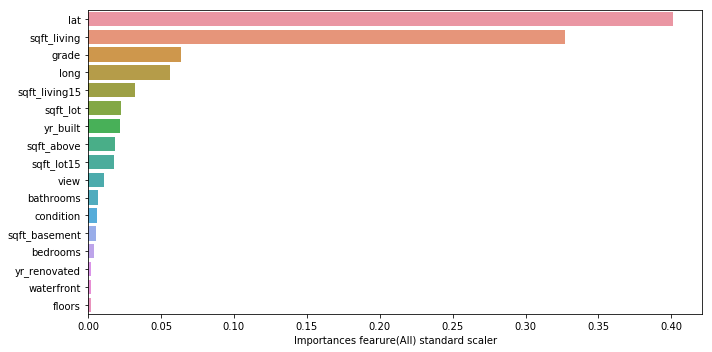

In [26]:
rf = RandomForestRegressor(n_estimators=20, max_features='auto')
rf.fit(X_train_sc, y_train)

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train_sc.columns.values[ranking], orient='h')
ax.set_xlabel("Importances fearure(All) standard scaler")
plt.tight_layout()
plt.show()

##### 考察)
標準化前と特徴量の重要度が変わっていないため大きな影響はないと判断

### 改築された年

In [27]:
# 古い
df_data['yr_renovated'].value_counts().sort_index().head(10)

0       20699
1934        1
1940        2
1944        1
1945        3
1946        2
1948        1
1950        2
1951        1
1953        3
Name: yr_renovated, dtype: int64

In [28]:
#新しい 
df_data['yr_renovated'].value_counts().sort_index().tail(10)

2006    24
2007    35
2008    18
2009    22
2010    18
2011    13
2012    11
2013    37
2014    91
2015    16
Name: yr_renovated, dtype: int64

In [29]:
# 改築されていない物件とされている物件の数
s_renov = (df_data['yr_renovated']  != 0).value_counts()
print('改築された物件数=',s_renov[True])
print('改築されていない物件数=',s_renov[False])
print('比率=','{0:.3}'.format(s_renov[True] / s_renov[False]*100),'%')

改築された物件数= 914
改築されていない物件数= 20699
比率= 4.42 %


In [30]:
# 1999年以降改築された物件とそれ以外の物件の数
s_renov = (df_data['yr_renovated']  > 1999).value_counts()
print('1999年以降に改築された物件数=',s_renov[True])
print('それ以外の物件数=',s_renov[False])
print('比率=','{0:.3}'.format(s_renov[True] / s_renov[False]*100),'%')

1999年以降に改築された物件数= 458
それ以外の物件数= 21155
比率= 2.16 %


方針）改築されている物件は全体の4%程度なので改築の時期は考慮せずに改築したかしないかの値に変換する

### まとめ
- "waterfront","view","condition","grade"はone-hotベクトルに変換する
- "date"は日付型に変換する(月のみ)
- idは削除する
- sqft_living,sqft_above,sqft_basementは削除する
- priceが10万ドル以上は外れ値として除外する
- 改築されたかどうかを２値化する

## 前処理

In [99]:
df_pre = df_data.copy()
df_pre = df_pre[df_pre["price"] < 1.0]

### 日付変換

In [100]:
#　月に変換
df_pre['month'] = pd.to_datetime(df_pre.date).map(lambda x:x.month)

### 改築年を改築の有無に変更

In [101]:
df_pre['renovated_flag'] = np.array(df_pre['yr_renovated'] != 0)*1

### One-hot ベクトル化

In [102]:
df_pre = pd.get_dummies(df_pre,columns=['zipcode','month','waterfront','view','grade'])
df_pre.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated_flag', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zipcode_98077', '

### 不要項目を削除

In [103]:
df_pre = df_pre.drop(['id','date','yr_renovated','sqft_living','sqft_above','sqft_basement'],axis=1)

### 前処理後のデータ確認

In [104]:
df_pre.columns.values

array(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'condition', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated_flag', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102',
       'zipcode_98103', 'zipcode_98105', 'zipcode_

In [105]:
df_pre.head()

,price,bedrooms,bathrooms,sqft_lot,floors,condition,yr_built,lat,long,sqft_living15,...,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12
0,0.2219,3,1.00,5650,1.0,3,1955,47.5112,-122.257,1340,...,0,0,0,0,1,0,0,0,0,0
1,0.5380,3,2.25,7242,2.0,3,1951,47.7210,-122.319,1690,...,0,0,0,0,1,0,0,0,0,0
2,0.1800,2,1.00,10000,1.0,3,1933,47.7379,-122.233,2720,...,0,0,0,1,0,0,0,0,0,0
3,0.6040,4,3.00,5000,1.0,5,1965,47.5208,-122.393,1360,...,0,0,0,0,1,0,0,0,0,0
4,0.5100,3,2.00,8080,1.0,3,1987,47.6168,-122.045,1800,...,0,0,0,0,0,1,0,0,0,0


## 学習

### 訓練データとテストを分割

In [106]:
# Nanの除去
df = df_pre.dropna()

# scikit learnの入力形式に変換する
y = df['price'].as_matrix()
y = y.reshape(-1,1)
X = df.drop(columns='price').as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [107]:
# 学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)
print("決定係数=",regr.score(X_train,y_train))

決定係数= 0.8095134859418174


##### DAY2追加）
グリッドサーチおよびクロスバリデーションを追加して最適化が図れるか検証する  
（基礎集計の際に標準化は効果がないと想定しているが、実際に効果がないか検証する）

In [108]:
# GridSearchCVを用いてパラメータの最適化を行う
# 
tuned_params = [{'normalize': [True,False]}]
clf = GridSearchCV(LinearRegression(), param_grid=tuned_params, cv=5,return_train_score=False)
clf.fit(X_train, y_train)
print('best Params=',clf.best_estimator_)
print("決定係数=",clf.best_estimator_.score(X_train,y_train))
pd.DataFrame(clf.cv_results_)

best Params= LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
決定係数= 0.8095134859418174


,mean_fit_time,mean_score_time,mean_test_score,param_normalize,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.066302,0.000827,-5.640963e+18,True,{'normalize': True},2,-4.240023e+18,-2.396523e+19,0.801180,0.799299,0.818555,0.012824,0.000105,9.307807e+18
1,0.055235,0.000743,8.061306e-01,False,{'normalize': False},1,8.075713e-01,8.040514e-01,0.801183,0.799309,0.818538,0.000641,0.000021,6.802130e-03


#### DAY2追加考察）
標準化は効果がないことを確認した

In [109]:
# 推論
y_pred = regr.predict(X_test)
y_pred

array([[0.56872554],
       [0.30747773],
       [0.23354214],
       ...,
       [0.30646447],
       [0.34172817],
       [0.19208292]])

In [110]:
y_test

array([[0.62525],
       [0.369  ],
       [0.26   ],
       ...,
       [0.26   ],
       [0.398  ],
       [0.201  ]])

In [111]:
y_pred - y_test

array([[-0.05652446],
       [-0.06152227],
       [-0.02645786],
       ...,
       [ 0.04646447],
       [-0.05627183],
       [-0.00891708]])

### 精度の評価

In [112]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("MSE=%s"%round(mse,3) )
print("RMSE=%s"%round(np.sqrt(mse), 3) )
print("MAE=%s"%round(mae,3) )

MSE=0.008
RMSE=0.087
MAE=0.064
